<a href="https://colab.research.google.com/github/capozzolicaluan/TiltmeterAnalysis/blob/main/Tiltimeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1878]:
%reset -f

In [1879]:
# import drive from colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [1880]:
# import packages
import pandas as pd
from google.colab  import files
import io
from io import StringIO
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pickle

In [1881]:
os.chdir('/content/drive/MyDrive/Colab/TiltmetersAnalysis')

In [1882]:
# functions

# Convert date format function
def convert_date_format(date_string):
    # string with br date - time format "dd/mm/aaaa hh:mm:ss"
    dt_obj = datetime.strptime(date_string, '%d/%m/%Y %H:%M:%S')
    # Format as "aaaa-mm-dd hh:mm:ss"
    return dt_obj.strftime('%Y-%m-%d %H:%M:%S')

# convert datetime to hour fraction
def datetime_to_hour_frac(dt):
    return dt.hour + dt.minute / 60 + dt.second / 3600

# list tiltmeter folders
def list_folders(directory_path):

  # List folders in the directory
  folders = [f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))]

  return(folders)

# list files in specific tiltmeter folder
def list_files(file_directory):
  # list files in specific directory
  files = [f for f in os.listdir(file_directory) if os.path.isfile(os.path.join(file_directory, f))]

  return(files)

# function to organize tiltmeter data and clear uninteresting informations
def read_tilt_data(directory_file, tilt_files_list):
  file_path_one = "{}/{}".format(directory_file, tilt_files_list[1])
  file_path_two = "{}/{}".format(directory_file, tilt_files_list[2])

  axis_one = pd.read_csv((file_path_one), parse_dates=True, delimiter = ',',engine='c')
  axis_one = axis_one['Sample Date / Time,"Location","Sensor","Value","OB Temp"'].str.split(',', expand=True)
  axis_one = axis_one.apply(lambda x: x.str.strip('"'))
  axis_one.columns = ['Sample Date / Time', 'Location', 'Sensor', 'Value', 'OB Temp']

  axis_two = pd.read_csv((file_path_two), parse_dates=True, delimiter = ',',engine='c')
  axis_two = axis_two['Sample Date / Time,"Location","Sensor","Value","OB Temp"'].str.split(',', expand=True)
  axis_two = axis_two.apply(lambda x: x.str.strip('"'))
  axis_two.columns = ['Sample Date / Time', 'Location', 'Sensor', 'Value', 'OB Temp']

  # convert date-time format
  axis_one['Sample Date / Time'] = axis_one['Sample Date / Time'].apply(convert_date_format)
  axis_two['Sample Date / Time'] = axis_two['Sample Date / Time'].apply(convert_date_format)

  # convert date-time column to datetime type
  axis_one['Sample Date / Time'] = pd.to_datetime(axis_one['Sample Date / Time'])
  axis_two['Sample Date / Time'] = pd.to_datetime(axis_two['Sample Date / Time'])

  # Definir a coluna 'datetime_column' como o índice do DataFrame
  axis_one.set_index('Sample Date / Time', inplace=True)
  axis_two.set_index('Sample Date / Time', inplace=True)

  tilt_data = pd.DataFrame()

  tilt_data['Date-time'] = axis_one.index
  tilt_data.set_index('Date-time', inplace = True)
  tilt_data['Date-time'] = tilt_data.index
  tilt_data['Tilt_axis_one'] = pd.to_numeric(axis_one['Value'])
  tilt_data['Tilt_axis_two'] = pd.to_numeric(axis_two['Value'])
  tilt_data['Temperature'] = pd.to_numeric(axis_one['OB Temp'])

  return(tilt_data)

# calculate the tilt variation velocity
def tilt_velocity(tilt_difference_column, delta_time_column):
    velocity = pd.DataFrame()
    velocity = tilt_difference_column/delta_time_column
    velocity[0] = 0

    return(velocity)

# calculate the tilt variation acceleration
def tilt_acceleration(tilt_velocity_column, delta_time_column):
    acceleration = pd.DataFrame()
    acceleration = tilt_velocity_column.diff()/delta_time_column
    acceleration[0] = 0

    return(acceleration)

def daily_stats(subdaily_index, subdaily_variable):
  subdaily_df = pd.DataFrame()
  subdaily_df['variable'] = subdaily_variable
  subdaily_df.set_index = subdaily_index
  daily_df = subdaily_df['variable'].resample('D').agg(['mean', 'std', 'min', 'max'])

  return(daily_df)

def plot_daily(daily_var, error_bar_color):
  plt.figure(figsize = ((14, 8)))
  plt.subplot(2, 1, 1)
  # Plotar a média diária com barras de erro para desvio padrão e sombras para máximos e mínimos

  #plt.plot(daily_stats.index, daily_stats['mean'], label='Média Diária', color='blue')
  plt.plot(daily_var.index, daily_var['mean'], 'o', color='red', label='Média Diária', markersize = 2)

  # Adicionar barras de erro para desvio padrão
  plt.errorbar(daily_var.index, daily_var['mean'], yerr=daily_var['std'], fmt='o', color= error_bar_color, label='Desvio Padrão', capsize = 2, markersize = 2)

  # Adicionar sombra para valores máximo e mínimo
  plt.fill_between(daily_var.index, daily_var['min'], daily_var['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

In [1883]:
# 3. Adicionar o diretório ao sys.path
import sys
sys.path.append('/content/drive/MyDrive/Colab/TiltmetersAnalysis/functions/')

# 4. Importar e usar o módulo
import functions_module

In [1884]:
# Path to data directory
tilt_data_directory = '/content/drive/MyDrive/Colab/TiltmetersAnalysis/data'

# List folders in the directory
folders = list_folders(directory_path = tilt_data_directory)

# number folder in the list
folder_number=11

# files in the folder
files = list_files(file_directory = "{}/{}/".format(tilt_data_directory,folders[folder_number]))

In [1859]:
len(folders)

12

In [1860]:
tilt_data_directory,folders[folder_number]

('/content/drive/MyDrive/Colab/TiltmetersAnalysis/data', '1C1E')

In [1861]:
directory_path = "{}/{}/".format(tilt_data_directory,folders[folder_number])

# function read_tilt_dada merge axis one, axis two and temperature files
tilt_time_series = read_tilt_data(directory_file = directory_path, tilt_files_list = files)

In [1862]:
tilt_time_series

,Date-time,Tilt_axis_one,Tilt_axis_two,Temperature
Date-time,,,,
2023-07-07 09:02:04,2023-07-07 09:02:04,0.0000,0.0000,26.43
2023-07-07 09:07:05,2023-07-07 09:07:05,-0.0009,0.0001,26.75
2023-07-07 09:12:04,2023-07-07 09:12:04,-0.0006,0.0010,27.38
2023-07-07 09:17:04,2023-07-07 09:17:04,-0.0007,0.0021,27.23
2023-07-07 09:22:05,2023-07-07 09:22:05,-0.0009,0.0017,27.23
...,...,...,...,...
2024-04-11 02:02:29,2024-04-11 02:02:29,0.0111,-0.0116,23.26
2024-04-11 03:32:30,2024-04-11 03:32:30,0.0115,-0.0103,22.31
2024-04-11 04:02:30,2024-04-11 04:02:30,0.0118,-0.0099,22.63


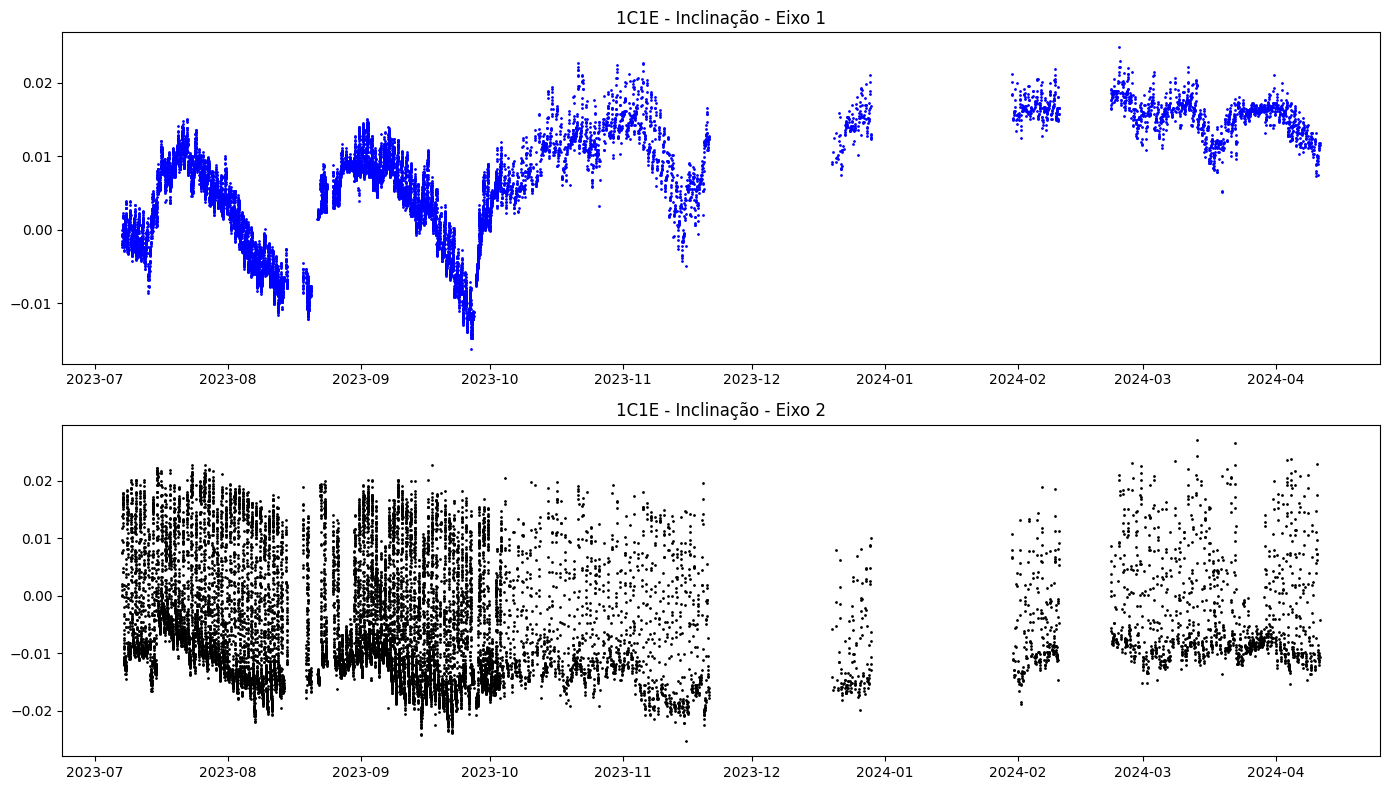

In [1863]:
# plot raw tilt data to detect instalation outliers - before outliers remotion
fig_raw, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(tilt_time_series.index, tilt_time_series['Tilt_axis_one'], 'o', color='blue', label='Média Diária', markersize = 1)
ax1.set_title("{} - Inclinação - Eixo 1".format(folders[folder_number]))

ax2.plot(tilt_time_series.index, tilt_time_series['Tilt_axis_two'], 'o', color='black', label='Média Diária', markersize = 1)
ax2.set_title("{} - Inclinação - Eixo 2".format(folders[folder_number]))

plt.tight_layout()
plt.show()

fig_raw.savefig("{}_001_dadosbrutos_semfiltro.png".format(folders[folder_number]))

In [1864]:
#tilt_time_series = tilt_time_series[tilt_time_series.iloc[:,2] < 2]

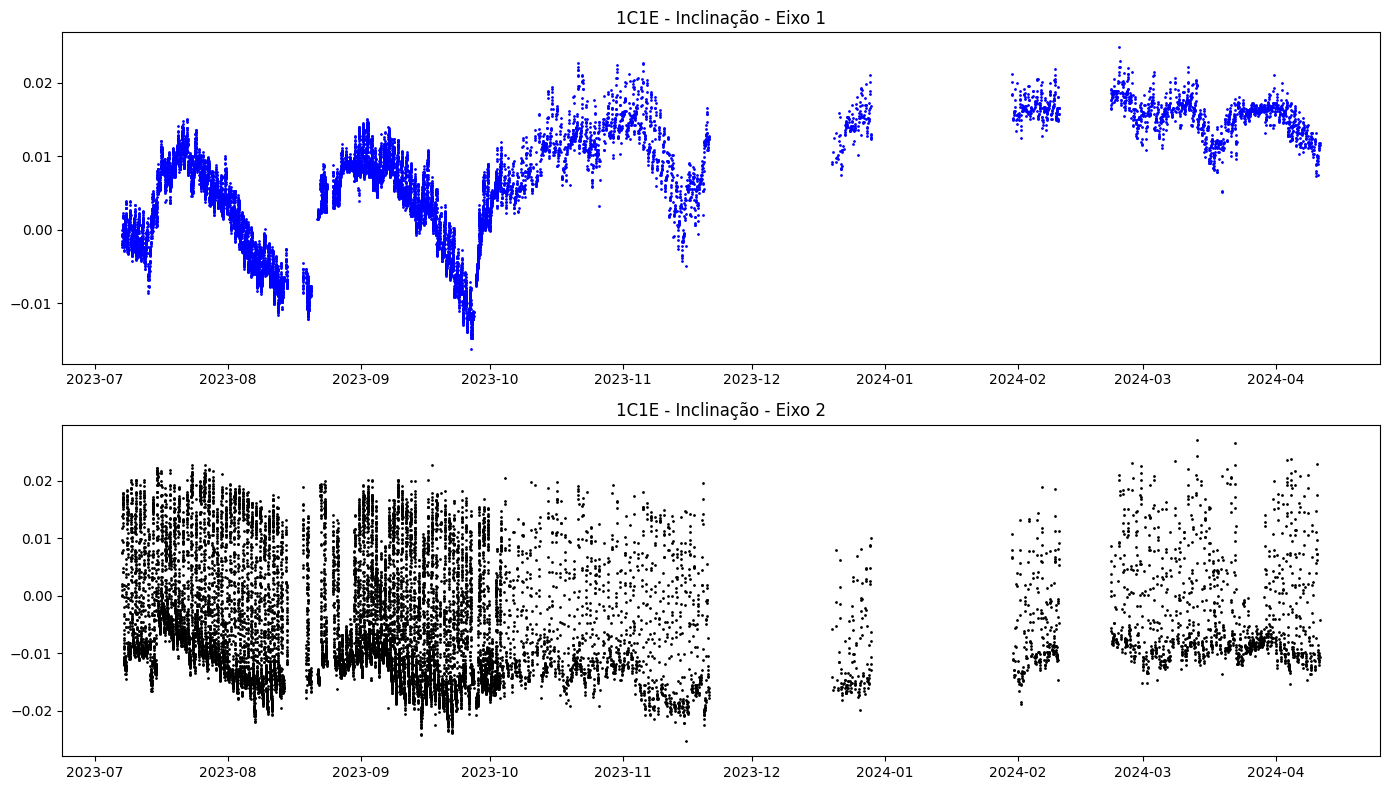

In [1865]:
# plot raw tilt data to detect instalation outliers - after outliers remotion
fig_raw, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(tilt_time_series.index, tilt_time_series['Tilt_axis_one'], 'o', color='blue', label='Média Diária', markersize = 1)
ax1.set_title("{} - Inclinação - Eixo 1".format(folders[folder_number]))

ax2.plot(tilt_time_series.index, tilt_time_series['Tilt_axis_two'], 'o', color='black', label='Média Diária', markersize = 1)
ax2.set_title("{} - Inclinação - Eixo 2".format(folders[folder_number]))

plt.tight_layout()
plt.show()

fig_raw.savefig("{}_002_dadosbrutos_filtrados.png".format(folders[folder_number]))

In [1866]:
# diff between lines
tilt_time_series['Tilt Axis One Difference'] = tilt_time_series.Tilt_axis_one.diff()
tilt_time_series['Tilt Axis Two Difference'] = tilt_time_series.Tilt_axis_two.diff()
tilt_time_series['Temperature Difference'] = tilt_time_series.Temperature.diff()

tilt_time_series['Tilt Axis One Difference'][0] = 0
tilt_time_series['Tilt Axis Two Difference'][0] = 0
tilt_time_series['Temperature Difference'][0] = 0

<ipython-input-1866-12b9bf450516>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tilt_time_series['Tilt Axis One Difference'][0] = 0
<ipython-input-1866-12b9bf450516>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tilt_time_series['Tilt Axis Two Difference'][0] = 0
<ipython-input-1866-12b9bf450516>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tilt_time_series['Temperature Difference'][0] = 0


In [1867]:
tilt_time_series['Cum Tilt Axis One'] = tilt_time_series['Tilt Axis One Difference'].cumsum()
tilt_time_series['Cum Tilt Axis Two'] = tilt_time_series['Tilt Axis Two Difference'].cumsum()

In [1868]:
tilt_time_series

,Date-time,Tilt_axis_one,Tilt_axis_two,Temperature,Tilt Axis One Difference,Tilt Axis Two Difference,Temperature Difference,Cum Tilt Axis One,Cum Tilt Axis Two
Date-time,,,,,,,,,
2023-07-07 09:02:04,2023-07-07 09:02:04,0.0000,0.0000,26.43,0.0000,0.0000,0.00,0.0000,0.0000
2023-07-07 09:07:05,2023-07-07 09:07:05,-0.0009,0.0001,26.75,-0.0009,0.0001,0.32,-0.0009,0.0001
2023-07-07 09:12:04,2023-07-07 09:12:04,-0.0006,0.0010,27.38,0.0003,0.0009,0.63,-0.0006,0.0010
2023-07-07 09:17:04,2023-07-07 09:17:04,-0.0007,0.0021,27.23,-0.0001,0.0011,-0.15,-0.0007,0.0021
2023-07-07 09:22:05,2023-07-07 09:22:05,-0.0009,0.0017,27.23,-0.0002,-0.0004,0.00,-0.0009,0.0017
...,...,...,...,...,...,...,...,...,...
2024-04-11 02:02:29,2024-04-11 02:02:29,0.0111,-0.0116,23.26,0.0000,-0.0005,0.16,0.0111,-0.0116
2024-04-11 03:32:30,2024-04-11 03:32:30,0.0115,-0.0103,22.31,0.0004,0.0013,-0.95,0.0115,-0.0103
2024-04-11 04:02:30,2024-04-11 04:02:30,0.0118,-0.0099,22.63,0.0003,0.0004,0.32,0.0118,-0.0099


In [1869]:
# difference between times
tilt_time_series['delta_time'] = tilt_time_series['Date-time'].diff()

# NaT by date
tilt_time_series['delta_time'] = tilt_time_series['delta_time'].fillna(pd.Timedelta(seconds=0))

# column with delta time in hours
tilt_time_series['delta_time_hours'] = tilt_time_series['delta_time'].dt.total_seconds()/3600

In [1870]:
tilt_time_series['Axis One Velocity'] = tilt_velocity(tilt_difference_column = tilt_time_series['Tilt Axis One Difference'], delta_time_column = tilt_time_series['delta_time_hours'])
tilt_time_series['Axis Two Velocity'] = tilt_velocity(tilt_difference_column = tilt_time_series['Tilt Axis Two Difference'], delta_time_column = tilt_time_series['delta_time_hours'])

In [1871]:
tilt_time_series['Axis One Acceleration'] = tilt_acceleration(tilt_velocity_column= tilt_time_series['Axis One Velocity'], delta_time_column=tilt_time_series['delta_time_hours'])
tilt_time_series['Axis Two Acceleration'] = tilt_acceleration(tilt_velocity_column= tilt_time_series['Axis Two Velocity'], delta_time_column=tilt_time_series['delta_time_hours'])

In [1872]:
tilt_time_series

,Date-time,Tilt_axis_one,Tilt_axis_two,Temperature,Tilt Axis One Difference,Tilt Axis Two Difference,Temperature Difference,Cum Tilt Axis One,Cum Tilt Axis Two,delta_time,delta_time_hours,Axis One Velocity,Axis Two Velocity,Axis One Acceleration,Axis Two Acceleration
Date-time,,,,,,,,,,,,,,,
2023-07-07 09:02:04,2023-07-07 09:02:04,0.0000,0.0000,26.43,0.0000,0.0000,0.00,0.0000,0.0000,0 days 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2023-07-07 09:07:05,2023-07-07 09:07:05,-0.0009,0.0001,26.75,-0.0009,0.0001,0.32,-0.0009,0.0001,0 days 00:05:01,0.083611,-0.010764,0.001196,-0.128740,0.014304
2023-07-07 09:12:04,2023-07-07 09:12:04,-0.0006,0.0010,27.38,0.0003,0.0009,0.63,-0.0006,0.0010,0 days 00:04:59,0.083056,0.003612,0.010836,0.173091,0.116068
2023-07-07 09:17:04,2023-07-07 09:17:04,-0.0007,0.0021,27.23,-0.0001,0.0011,-0.15,-0.0007,0.0021,0 days 00:05:00,0.083333,-0.001200,0.013200,-0.057744,0.028367
2023-07-07 09:22:05,2023-07-07 09:22:05,-0.0009,0.0017,27.23,-0.0002,-0.0004,0.00,-0.0009,0.0017,0 days 00:05:01,0.083611,-0.002392,-0.004784,-0.014257,-0.215092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-11 02:02:29,2024-04-11 02:02:29,0.0111,-0.0116,23.26,0.0000,-0.0005,0.16,0.0111,-0.0116,0 days 00:30:00,0.500000,0.000000,-0.001000,0.001200,-0.002400
2024-04-11 03:32:30,2024-04-11 03:32:30,0.0115,-0.0103,22.31,0.0004,0.0013,-0.95,0.0115,-0.0103,0 days 01:30:01,1.500278,0.000267,0.000867,0.000178,0.001244
2024-04-11 04:02:30,2024-04-11 04:02:30,0.0118,-0.0099,22.63,0.0003,0.0004,0.32,0.0118,-0.0099,0 days 00:30:00,0.500000,0.000600,0.000800,0.000667,-0.000133


In [1873]:
daily_temperature = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Temperature'])

daily_tilt_one = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Tilt_axis_one'])
daily_tilt_two = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Tilt_axis_two'])

daily_velocity_one = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis One Velocity'])
daily_velocity_two = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis Two Velocity'])

daily_accelera_one = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis One Acceleration'])
daily_accelera_two = daily_stats(subdaily_index = tilt_time_series['Date-time'], subdaily_variable = tilt_time_series['Axis Two Acceleration'])

In [1874]:
# salva na pasta
with open("{}_eixo1dia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_tilt_one],f)

with open("{}_eixo2dia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_tilt_two],f)

with open("{}_tempdia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_temperature],f)

with open("{}_velo1dia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_velocity_one],f)

with open("{}_velo2dia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_velocity_two],f)

with open("{}_acel1dia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_accelera_one],f)

with open("{}_acel2dia.pkl".format(folders[folder_number]), mode = 'wb') as f:
  pickle.dump([daily_accelera_two],f)

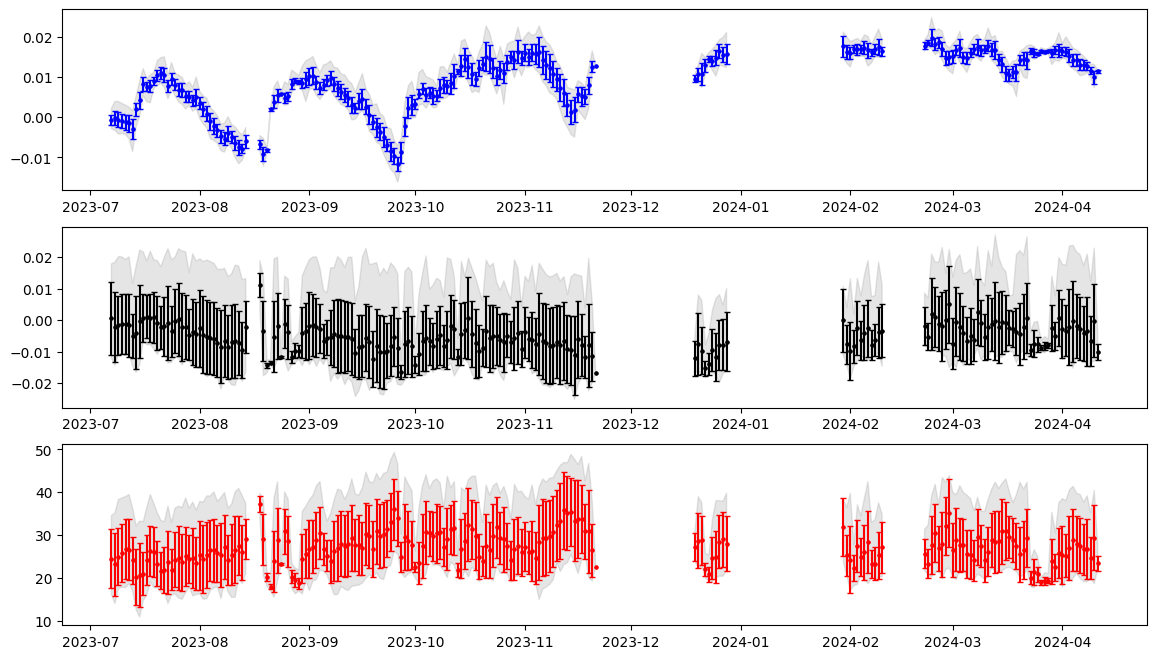

In [1875]:
# plot daily inclination with standart deviation and max/min
fig_daily, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 8))

ax1.plot(daily_tilt_one.index, daily_tilt_one['mean'], 'o', color='blue', label='Média Diária', markersize = 2)
ax1.errorbar(daily_tilt_one.index, daily_tilt_one['mean'], yerr=daily_tilt_one['std'], fmt='o', color= 'blue', label='Desvio Padrão', capsize = 2, markersize = 2)
ax1.fill_between(daily_tilt_one.index, daily_tilt_one['min'], daily_tilt_one['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

ax2.plot(daily_tilt_two.index, daily_tilt_two['mean'], 'o', color='black', label='Média Diária', markersize = 2)
ax2.errorbar(daily_tilt_two.index, daily_tilt_two['mean'], yerr=daily_tilt_two['std'], fmt='o', color= 'black', label='Desvio Padrão', capsize = 2, markersize = 2)
ax2.fill_between(daily_tilt_two.index, daily_tilt_two['min'], daily_tilt_two['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

ax3.plot(daily_temperature.index, daily_temperature['mean'], 'o', color='red', label='Média Diária', markersize = 2)
ax3.errorbar(daily_temperature.index, daily_temperature['mean'], yerr=daily_temperature['std'], fmt='o', color= 'red', label='Desvio Padrão', capsize = 2, markersize = 2)
ax3.fill_between(daily_temperature.index, daily_temperature['min'], daily_temperature['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

fig_daily.savefig("{}_003_serie_media_diaria.png".format(folders[folder_number]))

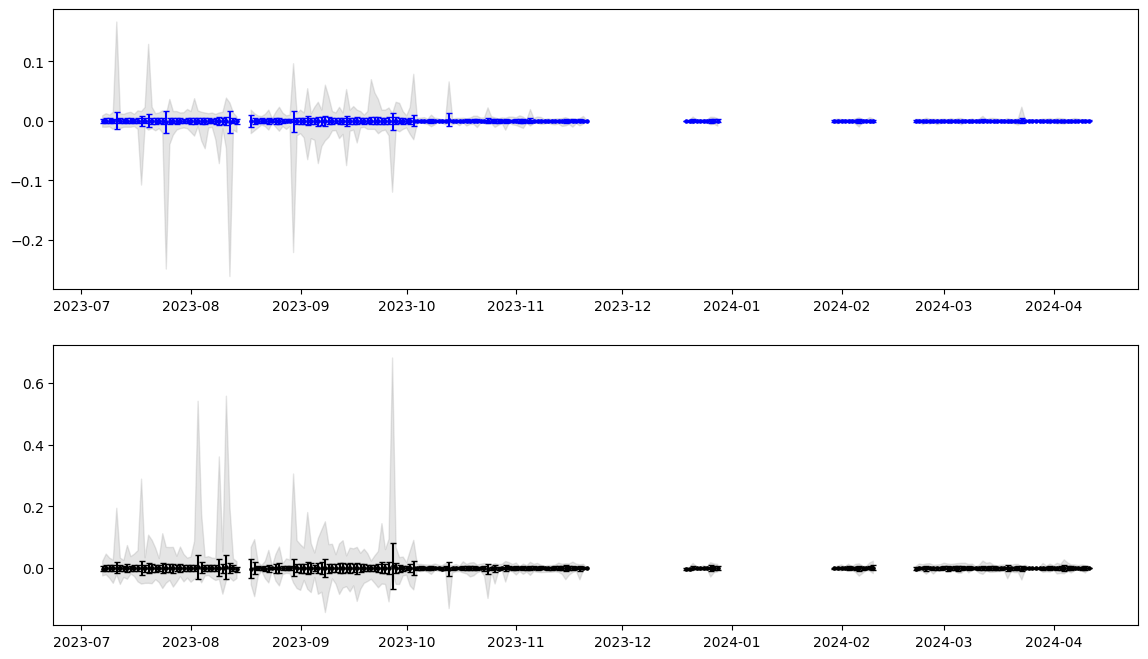

In [1876]:
# plot velocity with standart deviation and max/min
fig_daily_vel, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(daily_velocity_one.index, daily_velocity_one['mean'], 'o', color='blue', label='Média Diária', markersize = 2)
ax1.errorbar(daily_velocity_one.index, daily_velocity_one['mean'], yerr=daily_velocity_one['std'], fmt='o', color= 'blue', label='Desvio Padrão', capsize = 2, markersize = 2)
ax1.fill_between(daily_velocity_one.index, daily_velocity_one['min'], daily_velocity_one['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

ax2.plot(daily_velocity_two.index, daily_velocity_two['mean'], 'o', color='black', label='Média Diária', markersize = 2)
ax2.errorbar(daily_velocity_two.index, daily_velocity_two['mean'], yerr=daily_velocity_two['std'], fmt='o', color= 'black', label='Desvio Padrão', capsize = 2, markersize = 2)
ax2.fill_between(daily_velocity_two.index, daily_velocity_two['min'], daily_velocity_two['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

fig_daily_vel.savefig("{}_004_velocidade.png".format(folders[folder_number]))

plot_daily(daily_var = daily_velocity_one, error_bar_color = 'blue')

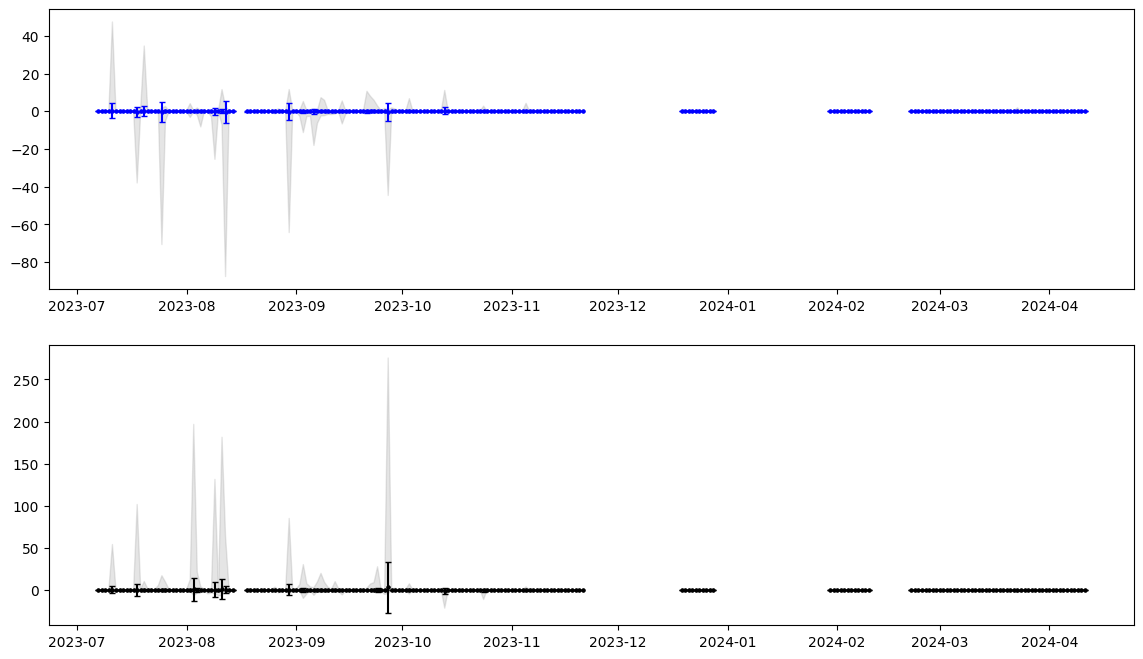

In [1877]:
# plot acceleration with standart deviation and max/min
fig_accel, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(daily_accelera_one.index, daily_accelera_one['mean'], 'o', color='blue', label='Média Diária', markersize = 2)
ax1.errorbar(daily_accelera_one.index, daily_accelera_one['mean'], yerr=daily_accelera_one['std'], fmt='o', color= 'blue', label='Desvio Padrão', capsize = 2, markersize = 2)
ax1.fill_between(daily_accelera_one.index, daily_accelera_one['min'], daily_accelera_one['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

ax2.plot(daily_accelera_two.index, daily_accelera_two['mean'], 'o', color='black', label='Média Diária', markersize = 2)
ax2.errorbar(daily_accelera_two.index, daily_accelera_two['mean'], yerr=daily_accelera_two['std'], fmt='o', color= 'black', label='Desvio Padrão', capsize = 2, markersize = 2)
ax2.fill_between(daily_accelera_two.index, daily_accelera_two['min'], daily_accelera_two['max'], color='gray', alpha=0.2, label='Máximo e Mínimo')

fig_accel.savefig("{}_005_aceleracao.png".format(folders[folder_number]))